VAE

    Создайте VAE с latent_size = 2, обучите его на MNIST. Можно использовать код с занятия
    Создайте при помощи np.linspace двумерную сетку, покрывающую латентное пространство (скажем, c разрешением 20 x 20 точек и покрывающую диапазон 3σ стандартного нормального распределения).
    Постройте при помощи генератора (декодера) изображдение для каждой из точек в латентном простарнстве. Желательно совместить изображенгия при помощи subplots так, чтобы они соотвествовали положению точек на сетке.
    В результате должно получиться что-то такое:


In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])


def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train - valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()


def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k: [z for z in zip(*log[k])] for k in keys}
    epochs = {k: range(len(log[k])) for k in keys}

    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import os 

%matplotlib inline

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
root_folder = 'FC_VAE_log_results'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/AE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(AE_folder)

In [5]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [6]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 10))
fixed_data, _ = next(iter(test_loader))

In [7]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh, flatten=False):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [8]:
class Net(nn.Module):
    def __init__(self, latent_size=2, gamma=1e-3, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
    
        self.latent_size = latent_size
        self.gamma = gamma

        self.fce = FullyConnected([784, 512, 128, latent_size*2], activation_fn=nn.ReLU, flatten=True)
        self.fcd = FullyConnected([latent_size, 128, 512, 784], activation_fn=nn.ReLU)
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
    
    def encode(self, x):
        h = self.fce(x)
        self.mu, self.logvar = h.split(self.latent_size, dim=1)
        return self.mu, self.logvar
    
    def decode(self, h):
        flatten = torch.tanh(self.fcd(h))
        x = flatten.view(-1, 1, 28, 28)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        if self.training:
            std = logvar.mul(0.5).exp()
            h = self._sample(mu.shape[0]) * std + mu
        else:
            h = mu
        x = self.decode(h)
        return x
    
    def _sample(self, n):
        return torch.randn([n, self.latent_size])
    
    def loss(self, output, target, size_average=True):
        KLD = self.mu ** 2 + self.logvar.exp() - 1 - self.logvar
        KLD = 0.5 * KLD.sum(1)
        if size_average:
            self.KLD = KLD.mean()
            self._loss = F.mse_loss(output, target, reduction='mean')
        else:
            self.KLD = KLD.sum()
            self._loss = F.mse_loss(output, target, reduction='sum')
        
        return self._loss + self.gamma*self.KLD

In [9]:
models = {'VAE10': Net(2, 0.005, batchnorm=False, dropout=False, optim_type='Adam', lr=1e-4)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [10]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [11]:
def test(models, loader, epoch, log=None):
    test_size = len(loader)
    test_reconstruction_loss = {k: 0. for k in models}
    test_KL_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                m.loss(output[k], data)
                test_reconstruction_loss[k] += m._loss.item()
                test_KL_loss[k] += m.KLD.item()
    
    for k in models:
        test_reconstruction_loss[k] /= test_size
        test_KL_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.4f}/{:.4f}'.format(k, 
                                                                    test_reconstruction_loss[k], 
                                                                    test_KL_loss[k]) for k in models])
    for k in models:
        if log is not None:
            log[k].append((test_reconstruction_loss[k], test_KL_loss[k]))
        with torch.no_grad():
            ae_data = models[k](fixed_data).data.numpy()
            fixed_gen = models[k].decode(fixed_z).data.numpy()
            plot_mnist(ae_data, (5, 10)) #, True) # , AE_folder + '/%s_%03d.png' % (k, epoch))
            plot_mnist(fixed_gen, (5, 10)) #, True)  # , fixed_folder + '/%s_%03d.png' % (k, epoch))
    print(report)

In [12]:
for epoch in range(1, 31):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    #test(models, valid_loader, epoch, test_log)

/opt/miniconda/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Train Epoch: 1 [0/50000 (0%)]	Losses VAE10: 0.9392
Train Epoch: 1 [10000/50000 (20%)]	Losses VAE10: 0.2659
Train Epoch: 1 [20000/50000 (40%)]	Losses VAE10: 0.2401
Train Epoch: 1 [30000/50000 (60%)]	Losses VAE10: 0.2211
Train Epoch: 1 [40000/50000 (80%)]	Losses VAE10: 0.2263
Train Epoch: 1 [50000/50000 (100%)]	Losses VAE10: 0.1941
Train Epoch: 2 [0/50000 (0%)]	Losses VAE10: 0.2062
Train Epoch: 2 [10000/50000 (20%)]	Losses VAE10: 0.2022
Train Epoch: 2 [20000/50000 (40%)]	Losses VAE10: 0.1935
Train Epoch: 2 [30000/50000 (60%)]	Losses VAE10: 0.2040
Train Epoch: 2 [40000/50000 (80%)]	Losses VAE10: 0.2065
Train Epoch: 2 [50000/50000 (100%)]	Losses VAE10: 0.1982
Train Epoch: 3 [0/50000 (0%)]	Losses VAE10: 0.2202
Train Epoch: 3 [10000/50000 (20%)]	Losses VAE10: 0.1997
Train Epoch: 3 [20000/50000 (40%)]	Losses VAE10: 0.2028
Train Epoch: 3 [30000/50000 (60%)]	Losses VAE10: 0.1857
Train Epoch: 3 [40000/50000 (80%)]	Losses VAE10: 0.1928
Train Epoch: 3 [50000/50000 (100%)]	Losses VAE10: 0.1957
Trai

## Создайте при помощи np.linspace двумерную сетку, покрывающую латентное пространство (скажем, c разрешением 20 x 20 точек и покрывающую диапазон 3σ стандартного нормального распределения).

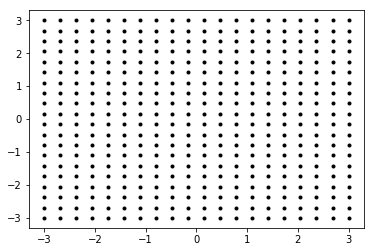

In [35]:
import numpy as np
import matplotlib.pyplot as plt
x_axis = np.linspace(-3,3,20) # чувствую, что вот где-то тут подстава
y_axis = np.linspace(-3,3,20)
xx, yy = np.meshgrid(x_axis, y_axis)
# следующая строчка только для визуализации сетки, как будут располагаться точки
_ = plt.plot(xx, yy, marker='.', color='k', linestyle='none')

zuzu = np.meshgrid(x_axis, y_axis)
#matrix = np.reshape(zuzu, (-1, 2))
matrix1 = torch.Tensor(zuzu)

## Постройте при помощи генератора (декодера) изображдение для каждой из точек в латентном простарнстве. Желательно совместить изображенгия при помощи subplots так, чтобы они соотвествовали положению точек на сетке. 

In [103]:
output1 = models['VAE10'].decode(matrix1 .float())

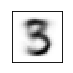

In [104]:
fixed_gen = models['VAE10'].decode(matrix1[0].float()).data.numpy()
plot_mnist(fixed_gen, (20, 20)) #

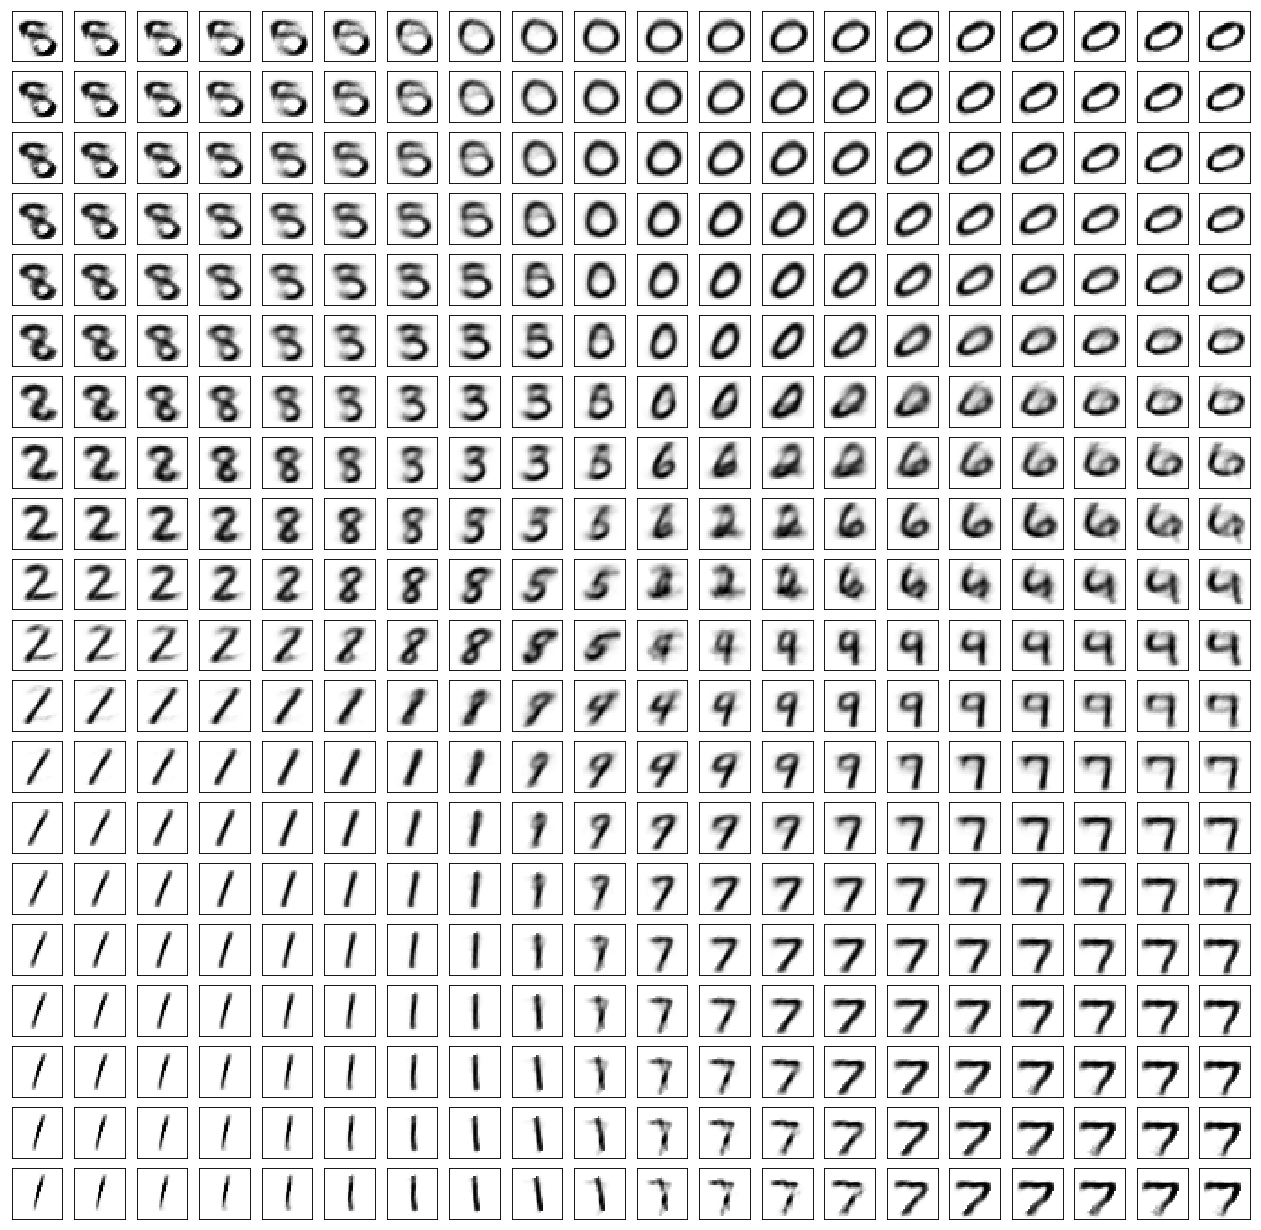

In [127]:
doter = []
for i in range(20):
    for q in range(20):
        #xer = []
        doter.append(xx[q][i])
        doter.append(yy[q][i])
    matrix = np.reshape(doter, (-1, 2))
    matrix1 = torch.Tensor(matrix)
fixed_gen = models['VAE10'].decode(matrix1.float()).data.numpy()
plot_mnist(fixed_gen, (20, 20))